<a href="https://colab.research.google.com/github/EsmaeilNarimissa/YouTube-DataDriven-Upgrade/blob/main/MAIN_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. **Data Enhancement and Feature Engineering**



## 1.1 Sample Data

The below code sample 2 random rows for each channel to get an idea of the data.

In [ ]:
import pandas as pd
import random
import warnings

# Suppress the specific DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*DataFrameGroupBy.apply operated on the grouping columns.*")

# Read the combined CSV file
df = pd.read_csv('combined_channels.csv')

# Get 2 random rows for each channel
sample_rows = df.groupby('channel').apply(lambda x: x.sample(n=2, random_state=random.randint(0, 1000))).reset_index(drop=True)

# Display the sampled rows
print(sample_rows.to_string())

       video_id                                                                                             title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
# Check the summary of the dataset to identify the columns, data types, and potential issues
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2993 entries, 0 to 2992
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                2993 non-null   object
 1   title                   2993 non-null   object
 2   description             2957 non-null   object
 3   published_at            2993 non-null   object
 4   thumbnails              2993 non-null   object
 5   tags                    2993 non-null   object
 6   category_id             2993 non-null   int64 
 7   default_language        2135 non-null   object
 8   default_audio_language  2979 non-null   object
 9   duration                2993 non-null   object
 10  definition              2993 non-null   object
 11  caption                 2993 non-null   bool  
 12  licensed_content        2993 non-null   bool  
 13  projection              2993 non-null   object
 14  views                   2993 non-null   int64 
 15  like

In [ ]:
import pandas as pd
import datetime
import json
from ast import literal_eval

def clean_youtube_data(df):
    # Make a copy to avoid modifying original data
    df_clean = df.copy()

    # Convert published_at to datetime
    df_clean['published_at'] = pd.to_datetime(df_clean['published_at'])

    # Convert duration string (PT1M38S) to seconds
    def parse_duration(duration):
        try:
            hours = 0
            minutes = 0
            seconds = 0

            if 'H' in duration:
                hours = int(duration.split('H')[0].replace('PT', ''))
                duration = duration.split('H')[1]
            if 'M' in duration:
                minutes = int(duration.split('M')[0].replace('PT', ''))
                duration = duration.split('M')[1]
            if 'S' in duration:
                seconds = int(duration.split('S')[0].replace('PT', ''))

            return hours * 3600 + minutes * 60 + seconds
        except:
            return None

    df_clean['duration_seconds'] = df_clean['duration'].apply(parse_duration)

    # Convert thumbnails string to dictionary
    def parse_thumbnails(thumb_str):
        try:
            return literal_eval(thumb_str)
        except:
            return None

    df_clean['thumbnails'] = df_clean['thumbnails'].apply(parse_thumbnails)

    # Convert tags from string to list
    def parse_tags(tags_str):
        try:
            return literal_eval(tags_str)
        except:
            return []

    df_clean['tags'] = df_clean['tags'].apply(parse_tags)

    return df_clean

# Read the data
df = pd.read_csv('combined_channels.csv')

# Clean the data
df_clean = clean_youtube_data(df)

# Basic statistics
print("\nDataset Overview:")
print(f"Total videos: {len(df_clean)}")
print("\nVideos per channel:")
print(df_clean['channel'].value_counts())

# Save cleaned dataset
df_clean.to_csv('cleaned_youtube_data.csv', index=False)


Dataset Overview:
Total videos: 2993

Videos per channel:
channel
healthgovau          2211
hmrcgovuk             314
ServicesAustralia     192
canrevagency          169
InlandRevenueNZ        57
AusTaxOffice           50
Name: count, dtype: int64


Summary of Results:
- **Total Videos**: 2,993 across all channels.
- **Videos per Channel**:
  - **healthgovau**: 2,211
  - **hmrcgovuk**: 314
  - **ServicesAustralia**: 192
  - **canrevagency**: 169
  - **InlandRevenueNZ**: 57
  - **AusTaxOffice**: 50



In [ ]:
import pandas as pd
import datetime
import json
from ast import literal_eval

def enhance_youtube_data(df):
    # Make a copy to avoid modifying original data
    df_clean = df.copy()

    # Handle empty strings vs NULL values
    df_clean['default_language'] = df_clean['default_language'].replace('', None)
    df_clean['default_audio_language'] = df_clean['default_audio_language'].replace('', None)

    # Clean description field - normalize whitespace and newlines
    df_clean['description'] = df_clean['description'].str.strip().str.replace('\n+', ' ', regex=True)

    # Add video length categorization
    df_clean['video_length_category'] = pd.cut(
        df_clean['duration_seconds'],
        bins=[0, 60, 300, 900, float('inf')],
        labels=['Short (0-1min)', 'Medium (1-5min)', 'Long (5-15min)', 'Extended (15min+)']
    )

    # Add engagement metrics
    df_clean['engagement_rate'] = (df_clean['likes'] + df_clean['comments']) / df_clean['views']
    df_clean['engagement_rate'] = df_clean['engagement_rate'].fillna(0)

    # Add publish date features
    df_clean['publish_year'] = pd.to_datetime(df_clean['published_at']).dt.year
    df_clean['publish_month'] = pd.to_datetime(df_clean['published_at']).dt.month
    df_clean['publish_day'] = pd.to_datetime(df_clean['published_at']).dt.day
    df_clean['publish_dayofweek'] = pd.to_datetime(df_clean['published_at']).dt.day_name()

    # Count number of tags
    df_clean['tag_count'] = df_clean['tags'].apply(lambda x: len(x) if isinstance(x, list) else 0)

    return df_clean

# Read the cleaned data
df = pd.read_csv('cleaned_youtube_data.csv')

# Apply enhancements
df_enhanced = enhance_youtube_data(df)

# Display summary statistics
print("\nDataset Overview:")
print(f"Total videos: {len(df_enhanced)}")

print("\nVideo Length Distribution:")
print(df_enhanced['video_length_category'].value_counts())

print("\nAverage Engagement Rate by Channel:")
print(df_enhanced.groupby('channel')['engagement_rate'].mean())

print("\nMost Common Publishing Days:")
print(df_enhanced['publish_dayofweek'].value_counts())

print("\nTag Usage Statistics:")
print(f"Average tags per video: {df_enhanced['tag_count'].mean():.2f}")
print(f"Videos with no tags: {(df_enhanced['tag_count'] == 0).sum()}")

# Save enhanced dataset
df_enhanced.to_csv('enhanced_youtube_data.csv', index=False)


Dataset Overview:
Total videos: 2993

Video Length Distribution:
video_length_category
Medium (1-5min)      1565
Short (0-1min)        881
Extended (15min+)     303
Long (5-15min)        241
Name: count, dtype: int64

Average Engagement Rate by Channel:
channel
AusTaxOffice         0.000313
InlandRevenueNZ      0.000149
ServicesAustralia    0.004572
canrevagency         0.005195
healthgovau          0.000073
hmrcgovuk            0.006313
Name: engagement_rate, dtype: float64

Most Common Publishing Days:
publish_dayofweek
Friday       697
Tuesday      623
Thursday     605
Wednesday    504
Monday       464
Sunday        77
Saturday      23
Name: count, dtype: int64

Tag Usage Statistics:
Average tags per video: 0.00
Videos with no tags: 2993


## 1.4 Data Enhancement v2

The code adds and calculates the following features in the YouTube dataset:

1. **View Performance Metrics**:
   - **`views_per_day`**: Average views per day since the video was published.

2. **Content Length Metrics**:
   - **`title_length`**: Character count of the video title.
   - **`description_length`**: Character count of the video description.

3. **Tag Count Metric**:
   - **`tag_count`**: Number of tags per video, where tags are counted if they exist in a list format.

4. **Thumbnail Quality Indicator**:
   - **`has_maxres_thumbnail`**: Boolean indicating whether the video has a high-resolution (`maxres`) thumbnail.

5. **Engagement Metrics**:
   - **`comments_per_view`**: Ratio of comments to views, showing comment frequency per view.
   - **`total_engagement`**: Sum of likes and comments, indicating total user interaction.
   - **`total_engagement_rate`**: Total engagement (likes + comments) as a ratio of views, indicating overall engagement rate.

These features provide deeper insights into viewership trends, content characteristics, and audience engagement for each video.

The enhanced dataset is saved as `enhanced_youtube_data_v2.csv`.


In [ ]:
def add_additional_metrics(df):
    # Make a copy to avoid modifying original data
    df_enhanced = df.copy()

    # Add view performance metrics
    df_enhanced['views_per_day'] = df_enhanced['views'] / (
        (pd.Timestamp.now() - pd.to_datetime(df_enhanced['published_at'])).dt.days + 1
    )

    # Add content length metrics
    df_enhanced['title_length'] = df_enhanced['title'].str.len()
    df_enhanced['description_length'] = df_enhanced['description'].str.len()

    # Add tag count metric (NEW)
    df_enhanced['tag_count'] = df_enhanced['tags'].apply(
        lambda x: len(eval(x)) if isinstance(x, str) and x != '[]' else 0
    )

    # Add thumbnail quality indicator
    df_enhanced['has_maxres_thumbnail'] = df_enhanced['thumbnails'].apply(
        lambda x: 'maxres' in x if isinstance(x, dict) else False
    )

    # Add engagement metrics
    df_enhanced['comments_per_view'] = df_enhanced['comments'] / df_enhanced['views']
    df_enhanced['total_engagement'] = df_enhanced['likes'] + df_enhanced['comments']
    df_enhanced['total_engagement_rate'] = df_enhanced['total_engagement'] / df_enhanced['views']

    # Fill NaN values with 0 for engagement metrics
    engagement_cols = ['comments_per_view', 'total_engagement_rate']
    df_enhanced[engagement_cols] = df_enhanced[engagement_cols].fillna(0)

    return df_enhanced

# Read the current enhanced CSV
df = pd.read_csv('enhanced_youtube_data.csv')

# Add additional metrics
df_final = add_additional_metrics(df)

# Save the final enhanced dataset
df_final.to_csv('enhanced_youtube_data_v2.csv', index=False)

# Display summary statistics of new metrics
print("\nNew Metrics Summary:")
print("\nContent Metrics:")
print(f"Average title length: {df_final['title_length'].mean():.1f} characters")
print(f"Average description length: {df_final['description_length'].mean():.1f} characters")
print(f"Average number of tags: {df_final['tag_count'].mean():.1f}")  # NEW
print(f"Videos with maxres thumbnails: {df_final['has_maxres_thumbnail'].sum()} ({df_final['has_maxres_thumbnail'].mean()*100:.1f}%)")

print("\nEngagement Metrics:")
print(f"Average views per day: {df_final['views_per_day'].mean():.2f}")
print(f"Average total engagement rate: {df_final['total_engagement_rate'].mean():.4f}")
print(f"Average comments per view: {df_final['comments_per_view'].mean():.4f}")


New Metrics Summary:

Content Metrics:
Average title length: 55.2 characters
Average description length: 399.3 characters
Average number of tags: 6.6
Videos with maxres thumbnails: 0 (0.0%)

Engagement Metrics:
Average views per day: 31.10
Average total engagement rate: 0.0013
Average comments per view: 0.0000


# 2. **Exploratory Data Analysis (EDA) - ALL Channels**

## 2.1 Basic Distribution Analysis

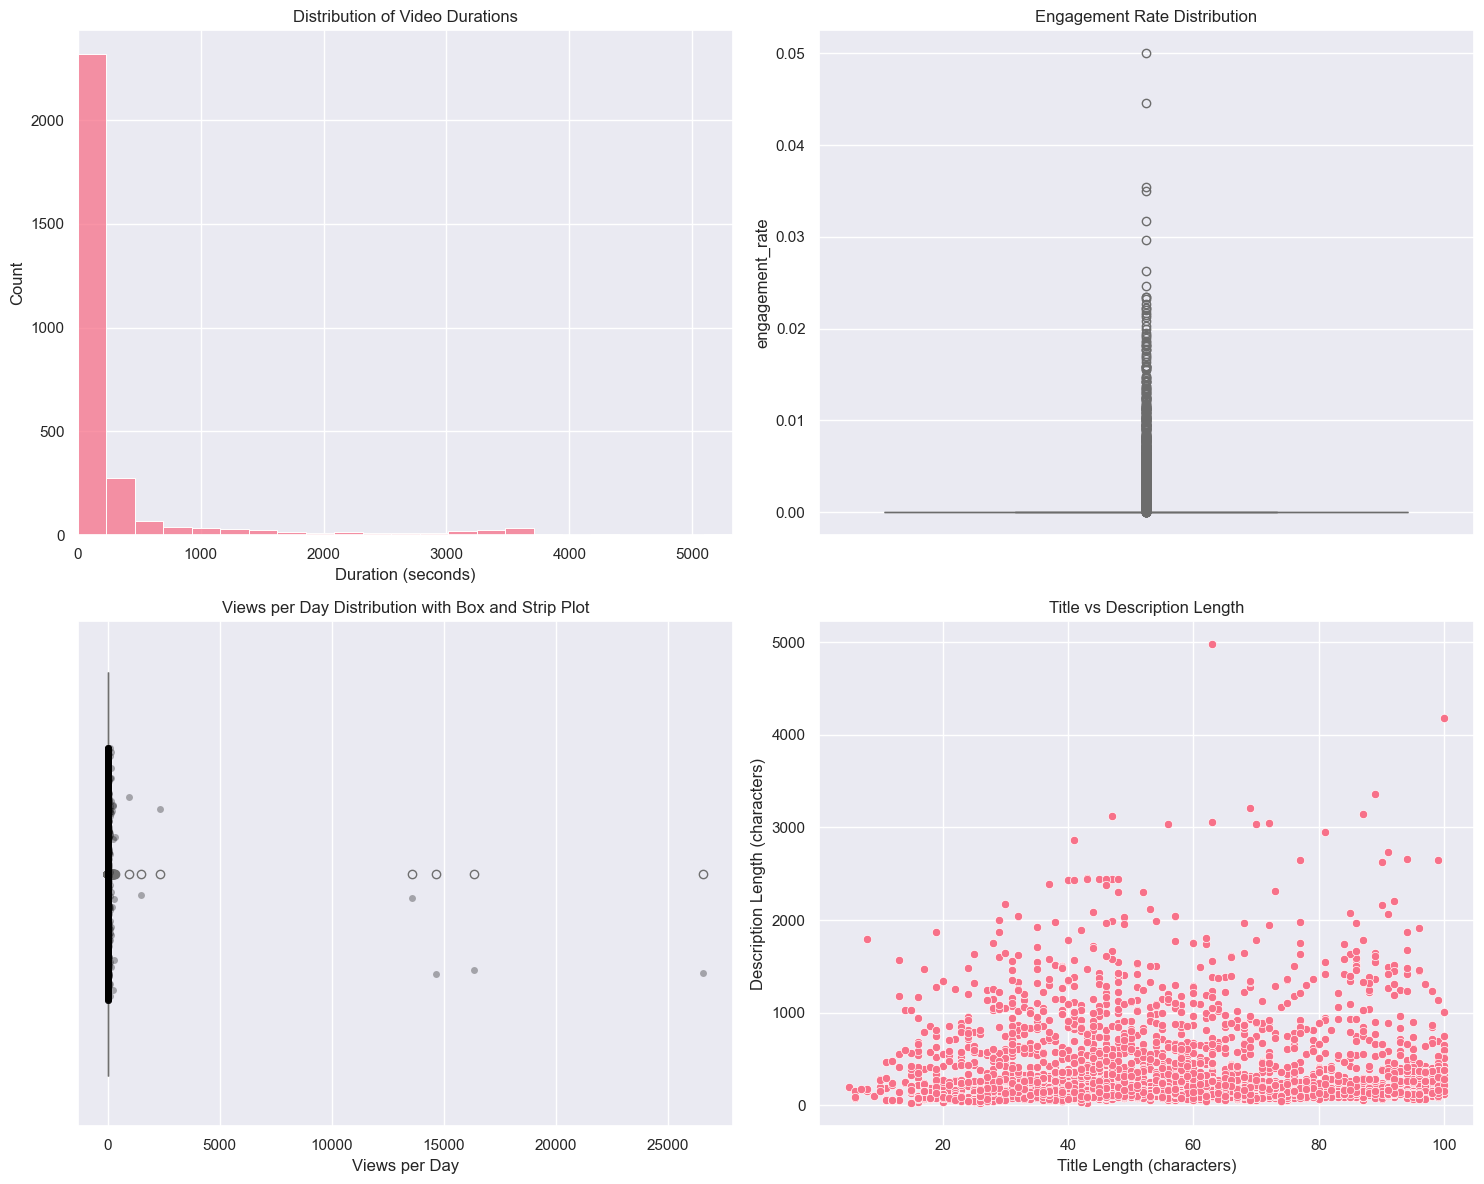


Numerical Features Summary:
       category_id         views        likes     comments  favorites  \
count  2993.000000  2.993000e+03  2993.000000  2993.000000     2993.0   
mean     26.491146  1.182402e+04     6.042432     0.001336        0.0   
std       0.957313  1.830956e+05    31.904822     0.051691        0.0   
min      22.000000  0.000000e+00     0.000000     0.000000        0.0   
25%      25.000000  9.700000e+01     0.000000     0.000000        0.0   
50%      27.000000  3.650000e+02     0.000000     0.000000        0.0   
75%      27.000000  1.890000e+03     0.000000     0.000000        0.0   
max      28.000000  7.046284e+06   736.000000     2.000000        0.0   

       duration_seconds  engagement_rate  publish_year  publish_month  \
count       2993.000000      2993.000000   2993.000000    2993.000000   
mean         394.541931         0.001311   2021.498162       6.050785   
std          936.936183         0.003680      2.372711       3.316034   
min            0.0000

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read the enhanced dataset
df = pd.read_csv('enhanced_youtube_data_v2.csv')

# Set seaborn style directly
sns.set_theme()  # This sets the default seaborn style
sns.set_palette("husl")

# Calculate reasonable maximum values for x-axis limits
max_duration = df['duration_seconds'].quantile(0.99)  # 99th percentile

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Video Length Distribution
sns.histplot(data=df, x='duration_seconds', bins=50, ax=axes[0,0])
axes[0,0].set_title('Distribution of Video Durations')
axes[0,0].set_xlabel('Duration (seconds)')
axes[0,0].set_xlim(0, max_duration)  # Set x-axis limit to 99th percentile

# 2. Engagement Metrics
sns.boxplot(data=df, y='engagement_rate', ax=axes[0,1])
axes[0,1].set_title('Engagement Rate Distribution')

# 3. Views per Day (Box plot with strip overlay)
sns.boxplot(data=df, x='views_per_day', ax=axes[1,0], color="skyblue")
sns.stripplot(data=df, x='views_per_day', ax=axes[1,0], color="black", alpha=0.3, jitter=0.25)
axes[1,0].set_title('Views per Day Distribution with Box and Strip Plot')
axes[1,0].set_xlabel('Views per Day')

# 4. Content Length
sns.scatterplot(data=df, x='title_length', y='description_length', ax=axes[1,1])
axes[1,1].set_title('Title vs Description Length')
axes[1,1].set_xlabel('Title Length (characters)')
axes[1,1].set_ylabel('Description Length (characters)')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nNumerical Features Summary:")
print(df.describe())

# Print categorical distributions
print("\nVideo Length Categories:")
print(df['video_length_category'].value_counts(normalize=True))



1. **Distribution Analysis**
- Video Duration: Most videos are clustered in shorter lengths (0-500 seconds), with a long tail of extended content
- Engagement Rate: Shows a right-skewed distribution with most videos having engagement rates below 0.02 (2%)
- Views per Day: Highly skewed distribution with most videos getting under 10 views per day, but some outliers performing exceptionally well
- Title vs Description Length: No strong linear relationship between title and description lengths



## 2.2 Temporal Analysis
This code creates two time-based visualizations:

1. **Average Views by Day of the Week**:
   - A bar plot displays the average number of views per video based on the day of the week it was published. The x-axis shows days.

2. **Average Engagement Rate Over Time**:
   - Converts the `published_at` column to datetime format, then groups data by month to calculate the average engagement rate.
   - A line plot shows the trend of the average engagement rate over time.



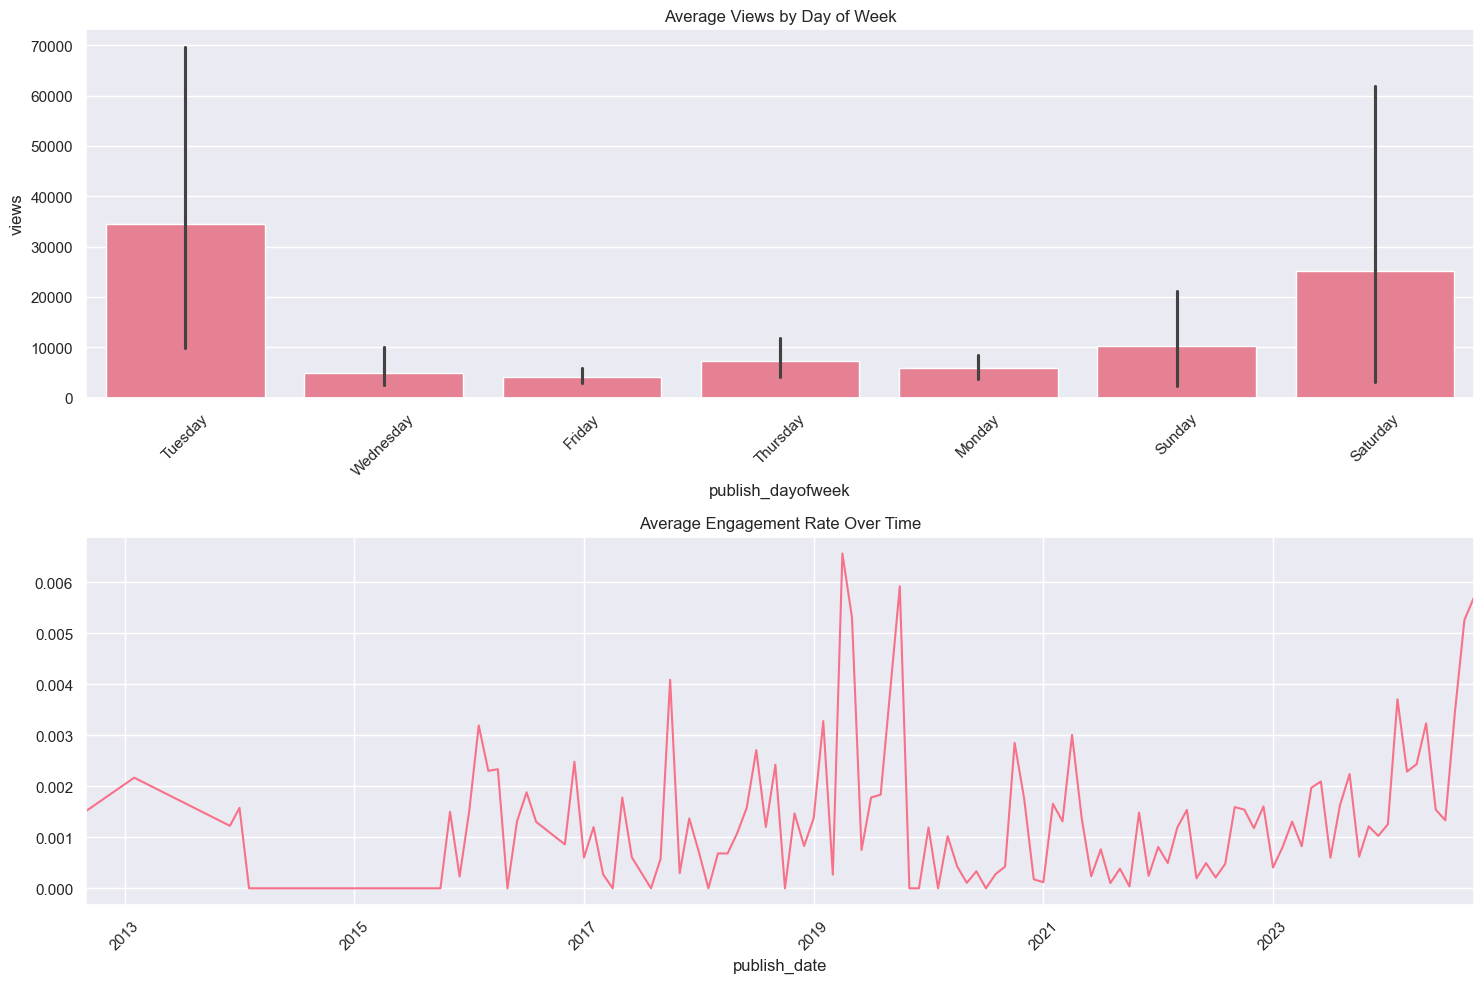

In [ ]:
# Create time-based visualizations
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Average views by publish day of week
sns.barplot(data=df, x='publish_dayofweek', y='views', ax=axes[0])
axes[0].set_title('Average Views by Day of Week')
axes[0].tick_params(axis='x', rotation=45)

# Engagement rate over time
df['publish_date'] = pd.to_datetime(df['published_at'])
monthly_engagement = df.groupby(df['publish_date'].dt.to_period('M'))['engagement_rate'].mean()
monthly_engagement.plot(ax=axes[1])
axes[1].set_title('Average Engagement Rate Over Time')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 2.3 **Time-Based Content and Engagement Analysis**


1. **Content Volume Analysis with Trend Line and Rolling Average**: Plots the monthly publishing volume of videos over time with a 6-month rolling average trend line, highlighting overall growth in content production and smoothing short-term fluctuations.

2. **Domain-specific Engagement Over Time**: Visualizes average engagement rates by domain (e.g., TAX, SERVICE, HEALTH) over time, allowing comparison of engagement trends across domains.

3. **Rolling Average Engagement Rate by Domain**: Provides a 3-month rolling average of engagement rates for each domain, further smoothing fluctuations and emphasizing longer-term engagement patterns.

4. **Seasonality Analysis of View Distribution**: Displays monthly view distribution using a box plot to detect seasonal variations in viewership, particularly highlighting patterns in different months.


<Figure size 1500x800 with 0 Axes>

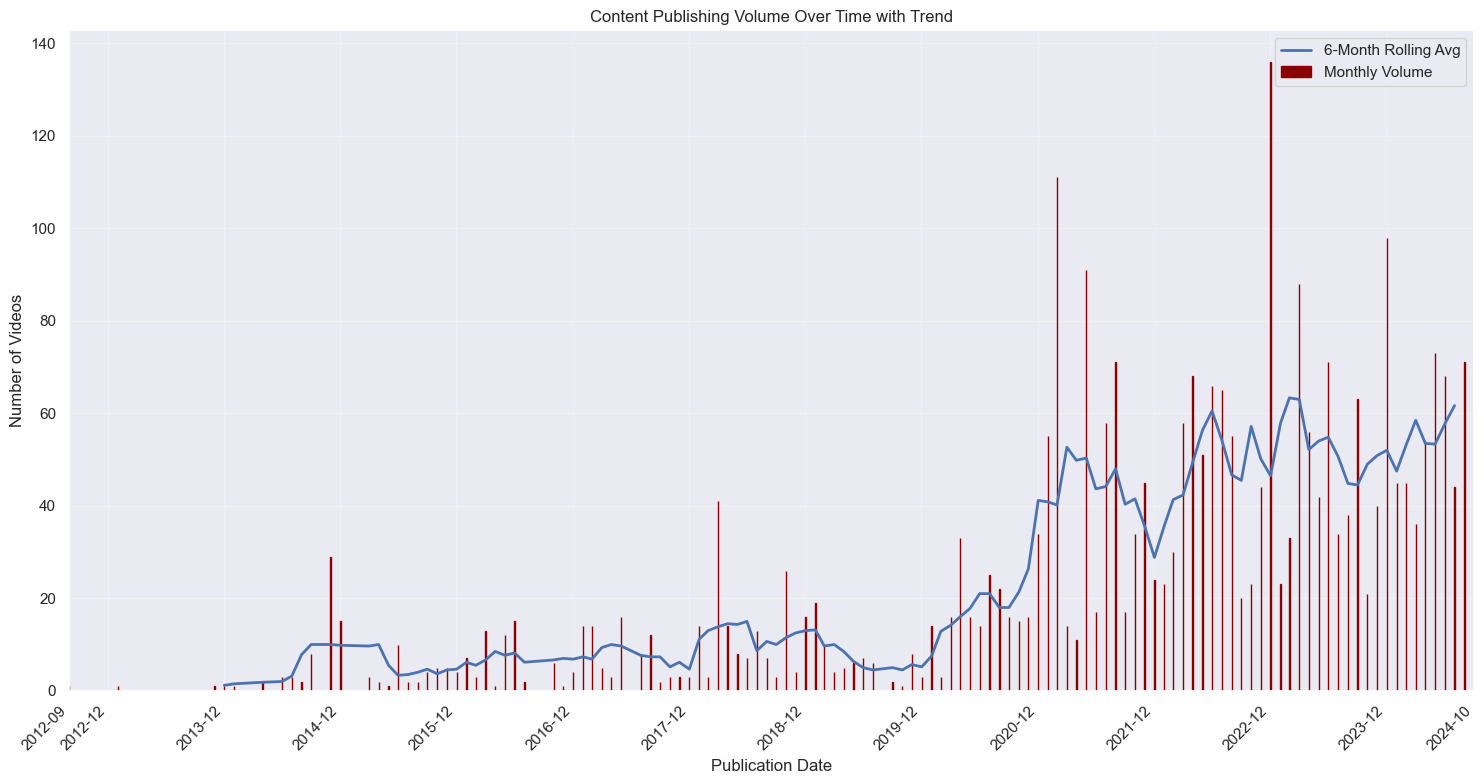

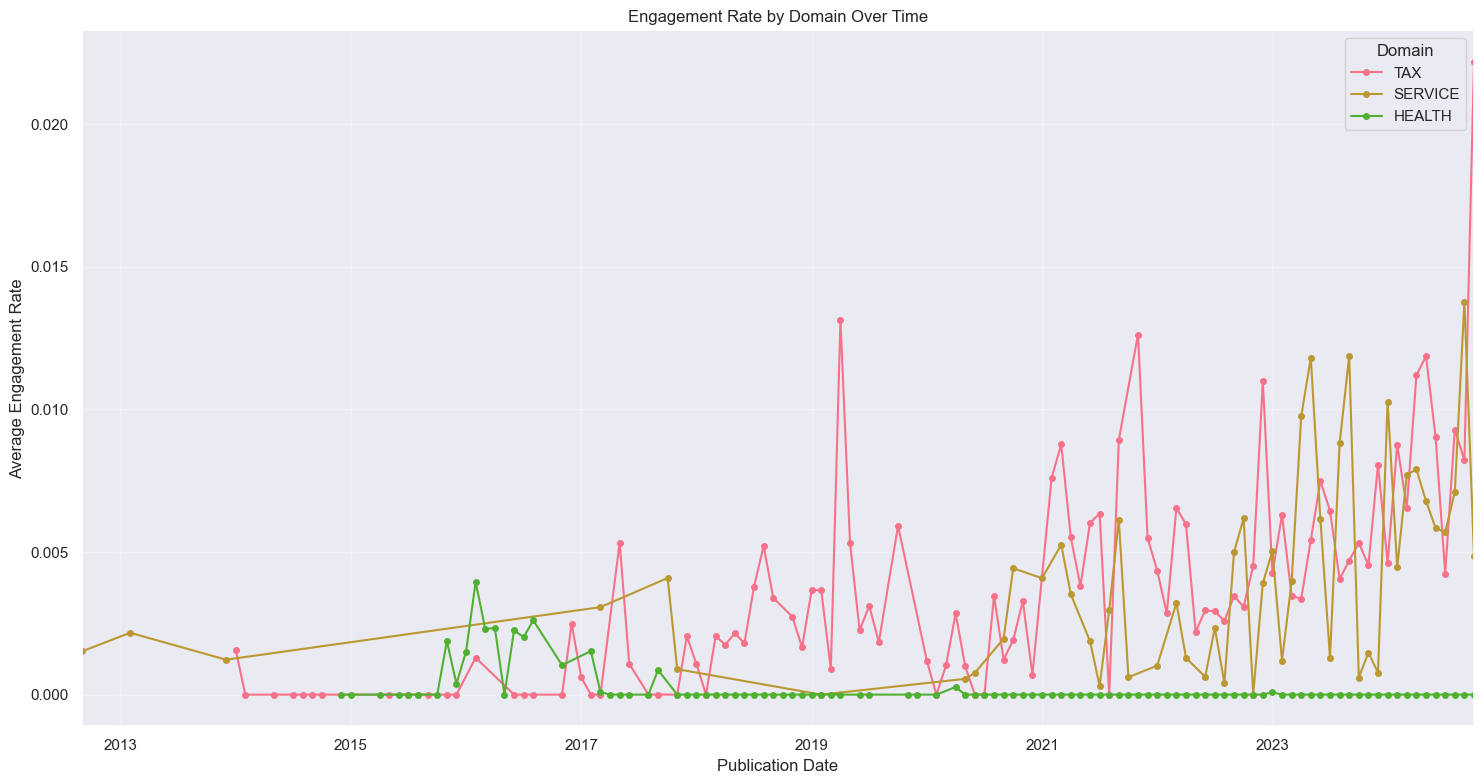

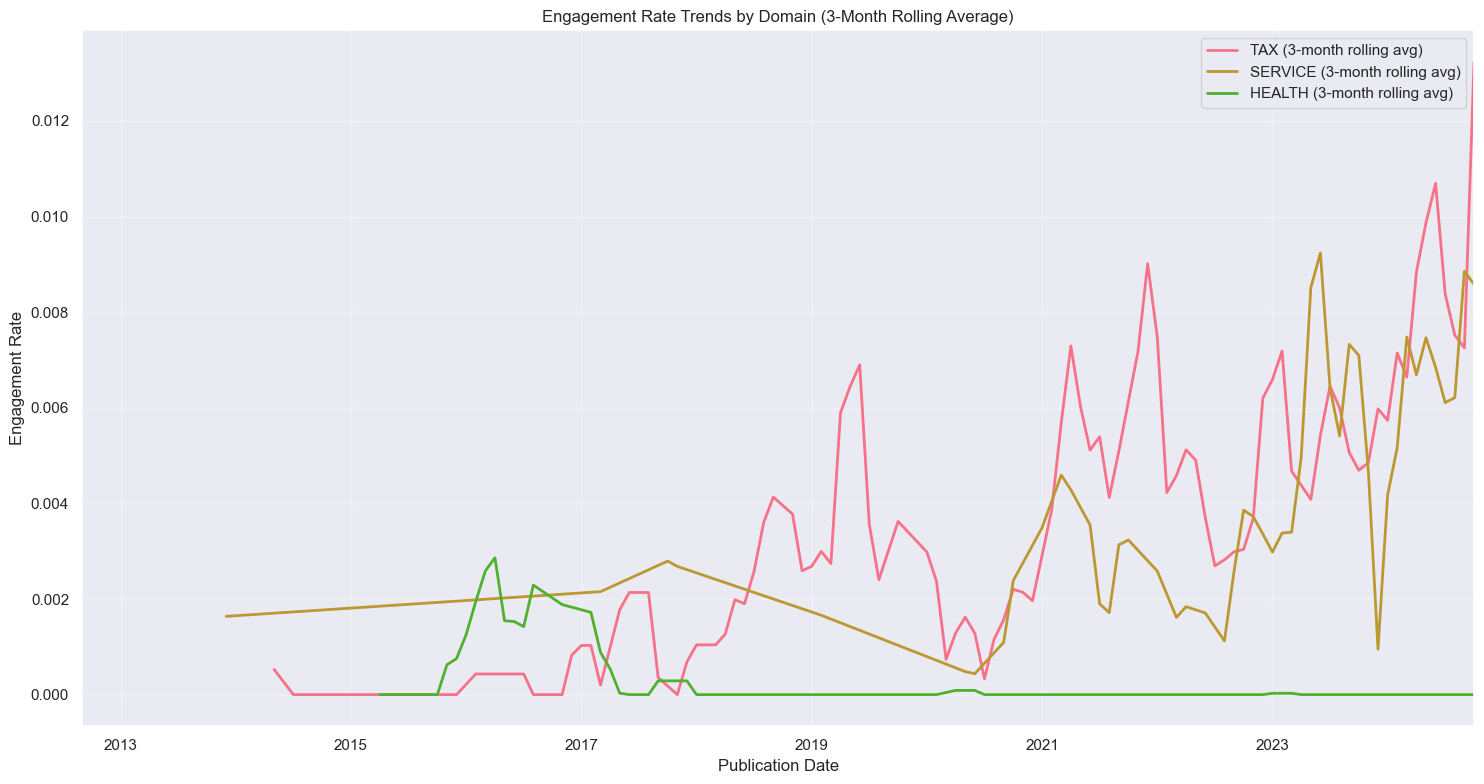

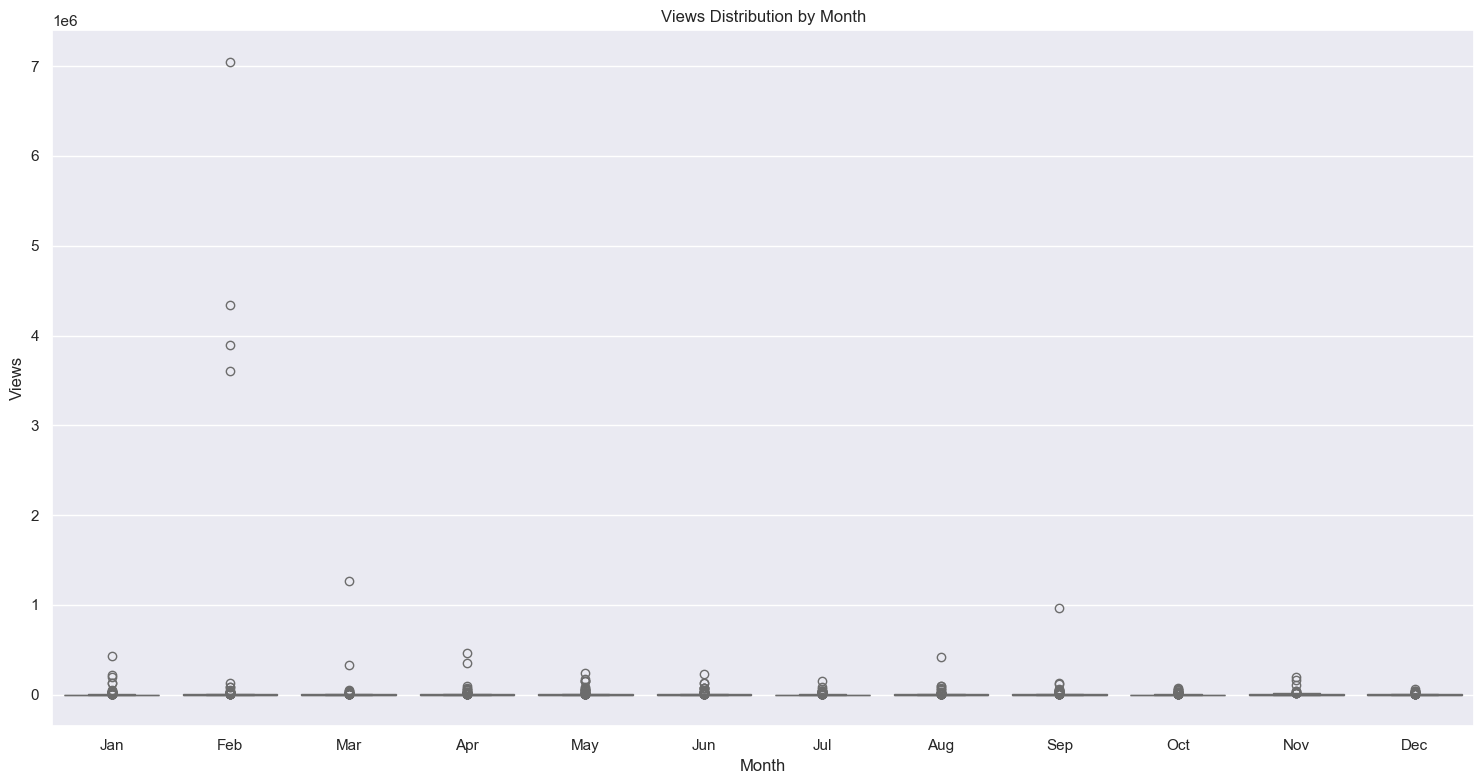

In [ ]:
# Add month column to the dataframe
df['month'] = pd.to_datetime(df['published_at']).dt.month
df['publish_date'] = pd.to_datetime(df['published_at'])

# 1. Content Volume Analysis with Trend Line and Rolling Average
plt.figure(figsize=(15, 8))

# Step 1: Prepare the data
content_volume = df.groupby(df['publish_date'].dt.to_period('M')).size()
content_volume.index = content_volume.index.astype(str).map(lambda x: pd.to_datetime(x))

# Step 2: Create figure and axis objects explicitly
fig, ax = plt.subplots(figsize=(15, 8))

# Step 3: Plot bars with explicit color
bars = ax.bar(content_volume.index,
              content_volume.values,
              facecolor='darkred',
              edgecolor='darkred',
              label='Monthly Volume')

# Step 4: Add rolling average
rolling_avg = content_volume.rolling(window=6, center=True).mean()
ax.plot(rolling_avg.index,
        rolling_avg.values,
        'b-',
        linewidth=2,
        label='6-Month Rolling Avg')

# Step 5: Customize the plot
ax.set_title('Content Publishing Volume Over Time with Trend')
ax.set_xlabel('Publication Date')
ax.set_ylabel('Number of Videos')
ax.legend()
ax.grid(True, alpha=0.3)

# Step 6: Format x-axis with specific date format and interval
# Get actual min and max dates from the data
min_date = content_volume.index.min()
max_date = content_volume.index.max()
ax.set_xlim(min_date, max_date)

# Create date range including min and max dates
date_range = pd.date_range(min_date, max_date, freq='Y')
# Add min and max dates if they're not already in the range
all_ticks = sorted(set(list(date_range) + [min_date, max_date]))
ax.set_xticks(all_ticks)
ax.set_xticklabels([d.strftime('%Y-%m') for d in all_ticks], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 2. Domain-specific Analysis
plt.figure(figsize=(15, 8))
for domain in df['domain'].unique():
    domain_data = df[df['domain'] == domain]
    monthly_domain = domain_data.groupby(domain_data['publish_date'].dt.to_period('M'))['engagement_rate'].mean()
    monthly_domain.plot(label=domain, marker='o', markersize=4)
plt.title('Engagement Rate by Domain Over Time')
plt.xlabel('Publication Date')
plt.ylabel('Average Engagement Rate')
plt.legend(title='Domain')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Rolling Average Analysis (moved here)
plt.figure(figsize=(15, 8))
for domain in df['domain'].unique():
    domain_data = df[df['domain'] == domain]
    monthly_engagement = domain_data.groupby(domain_data['publish_date'].dt.to_period('M'))['engagement_rate'].mean()
    # Plot 3-month rolling average
    rolling_avg = monthly_engagement.rolling(window=3).mean()
    rolling_avg.plot(label=f'{domain} (3-month rolling avg)', linewidth=2)

plt.title('Engagement Rate Trends by Domain (3-Month Rolling Average)')
plt.xlabel('Publication Date')
plt.ylabel('Engagement Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Seasonality Analysis
plt.figure(figsize=(15, 8))
sns.boxplot(data=df, x='month', y='views')
plt.title('Views Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Views')
# Add month names instead of numbers
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(12), month_names)
plt.tight_layout()
plt.show()

## 2.4 Engagement Analysis

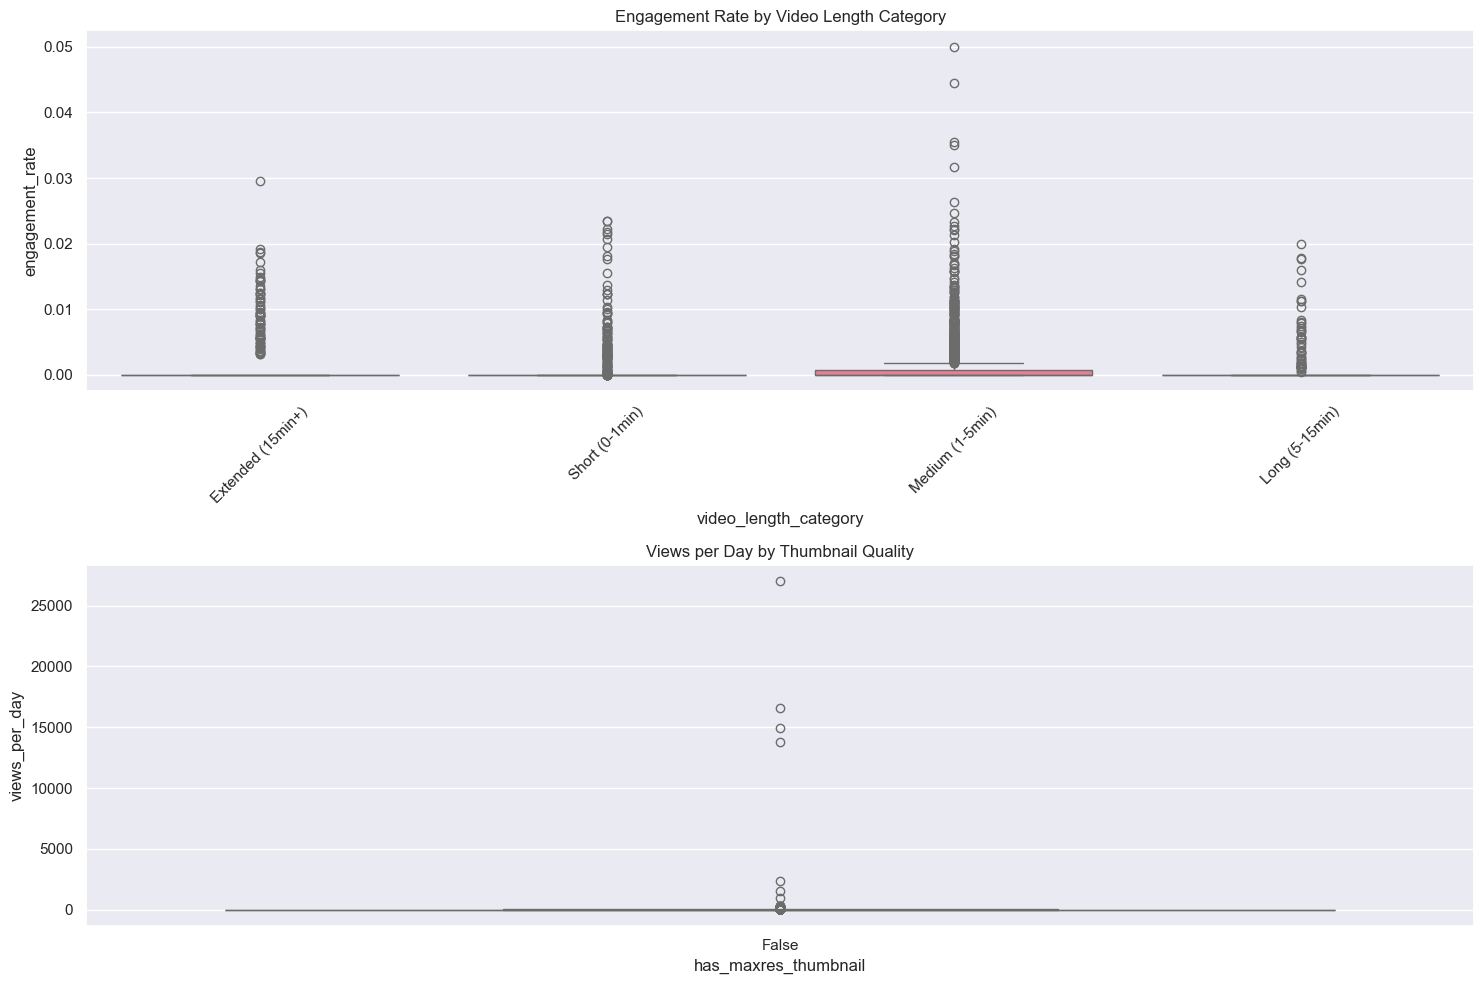


Engagement Statistics by Video Length:
                        count      mean       std  min  25%  50%       75%  \
video_length_category                                                        
Extended (15min+)       303.0  0.002182  0.004576  0.0  0.0  0.0  0.000000   
Long (5-15min)          241.0  0.001170  0.003177  0.0  0.0  0.0  0.000000   
Medium (1-5min)        1565.0  0.001486  0.003949  0.0  0.0  0.0  0.000718   
Short (0-1min)          881.0  0.000745  0.002780  0.0  0.0  0.0  0.000000   

                            max  
video_length_category            
Extended (15min+)      0.029630  
Long (5-15min)         0.019928  
Medium (1-5min)        0.050000  
Short (0-1min)         0.023454  


In [ ]:
# Create engagement metrics comparison
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Engagement by video length category
sns.boxplot(data=df, x='video_length_category', y='engagement_rate', ax=axes[0])
axes[0].set_title('Engagement Rate by Video Length Category')
axes[0].tick_params(axis='x', rotation=45)

# Impact of thumbnails on engagement
sns.boxplot(data=df, x='has_maxres_thumbnail', y='views_per_day', ax=axes[1])
axes[1].set_title('Views per Day by Thumbnail Quality')

plt.tight_layout()
plt.show()

# Print summary statistics by category
print("\nEngagement Statistics by Video Length:")
print(df.groupby('video_length_category')['engagement_rate'].describe())

## 2.5 **Title Length Impact and Top-Engaging Videos Analysis**

1. **Title Length Impact on Views per Day**:
   - This code generates a regression plot to analyze the **relationship between title length** and **views per day**. The plot helps determine if there’s a trend between the length of video titles and their average daily views, with `views_per_day` on the y-axis and `title_length` on the x-axis.

2. **Top-Engaging Videos**:
   - The code lists the **top 10 videos by engagement rate**, displaying key attributes: title, video length category, engagement rate, and total views. This table provides insight into the content characteristics of videos with the highest engagement, highlighting potential strategies for improving viewer interaction.

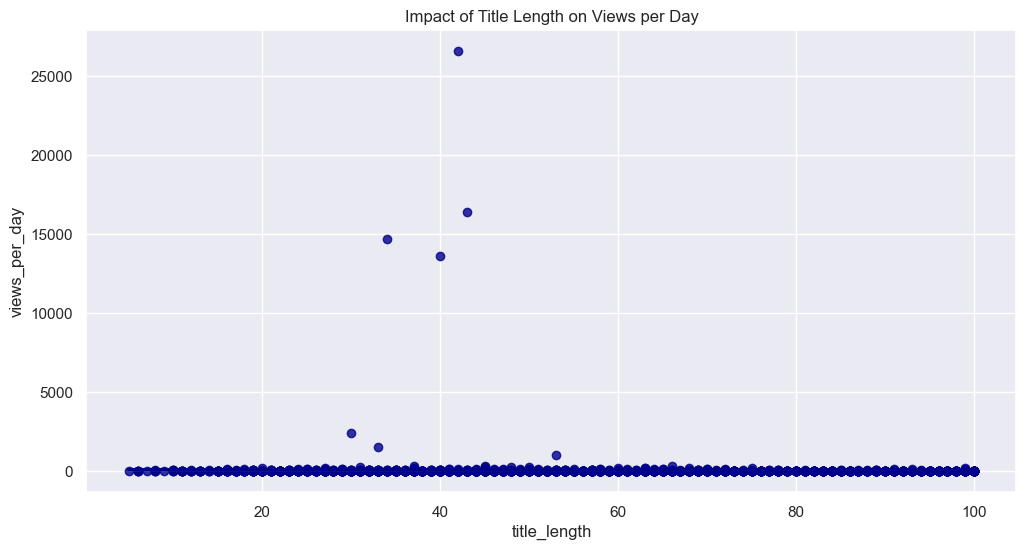


Top 10 Most Engaging Videos:
                                                 title video_length_category  \
173  Inside HMRC Estates: Meet Rich from Service De...       Medium (1-5min)   
174  How do I keep records for anti-money launderin...       Medium (1-5min)   
405  Making Tax Digital at Manchester Metropolitan ...       Medium (1-5min)   
169        What to do if you've been sent a tax return       Medium (1-5min)   
9                               Learn about your taxes       Medium (1-5min)   
0    What you need to know about maintaining charit...     Extended (15min+)   
489     In the community - Indigenous Service Officers       Medium (1-5min)   
177  Working as a Tax Specialist in Individuals and...       Medium (1-5min)   
568  Did you know we’ve got mobile service centres?...        Short (0-1min)   
565              Digital coaching | Services Australia        Short (0-1min)   

     engagement_rate  views  
173         0.050000     60  
174         0.044554    202  

In [ ]:
# Analyze title and description impact
plt.figure(figsize=(12, 6))
sns.regplot(data=df, x='title_length', y='views_per_day', color='darkblue')
plt.title('Impact of Title Length on Views per Day')
plt.show()

# Print top performing content characteristics
print("\nTop 10 Most Engaging Videos:")
print(df.nlargest(10, 'engagement_rate')[['title', 'video_length_category', 'engagement_rate', 'views']])

# 3. **Australian-Government Exploratory Analysis of Video Engagement and Publishing Strategies**

1. **Engagement Rate by Video Length and Domain**  
   Visualizes engagement rates for different video lengths across domains (e.g., TAX, HEALTH, SERVICE) using a box plot, providing insights into how video length impacts engagement within each domain.

2. **Correlation Analysis for Key Metrics**  
   Calculates and displays the correlation matrix for critical metrics, including views, engagement rate, video duration, title length, description length, and views per day. A heatmap visualizes these correlations, highlighting relationships between video characteristics and performance.

3. **Publishing Strategy Analysis**  
   Examines average views per day based on publishing day of the week and video length over the past two years. This analysis is shown with bar plots, helping identify optimal publishing times and effective video lengths to maximize daily views.

4. **3-Month Rolling Average Engagement Trends by Domain**  
   Plots the 3-month rolling average engagement rate for each domain over time, using distinct colors and line styles. This visualization smooths fluctuations to reveal long-term engagement trends across domains, emphasizing periods of higher audience engagement.

5. **Summary Statistics and Key Findings**  
   For each domain, computes and displays summary statistics, including average views per day, most effective video length, and optimal publishing day. This section provides actionable insights on content performance by domain.

This code facilitates a detailed domain-level analysis of engagement and publishing strategies, offering insights to optimize YouTube content for various sectors.

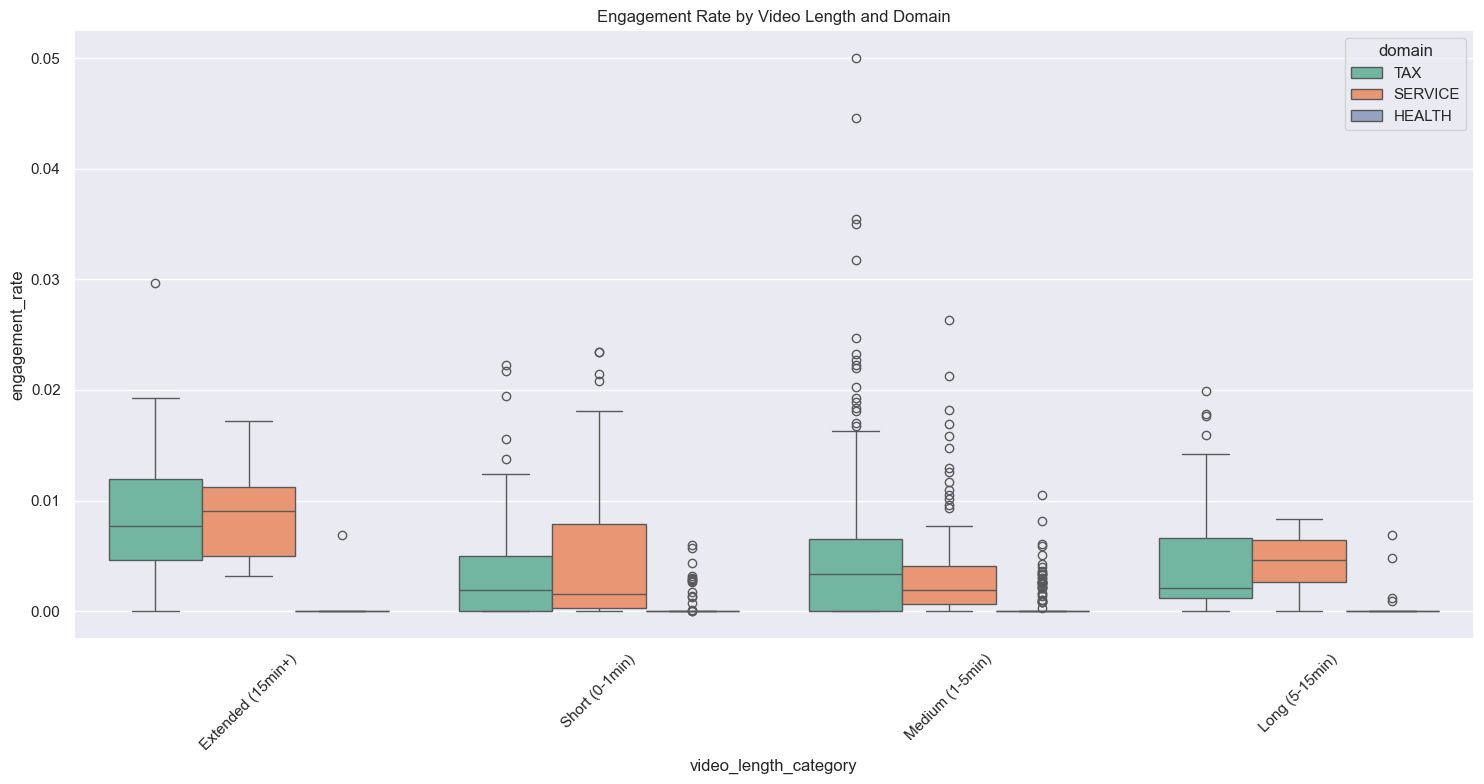

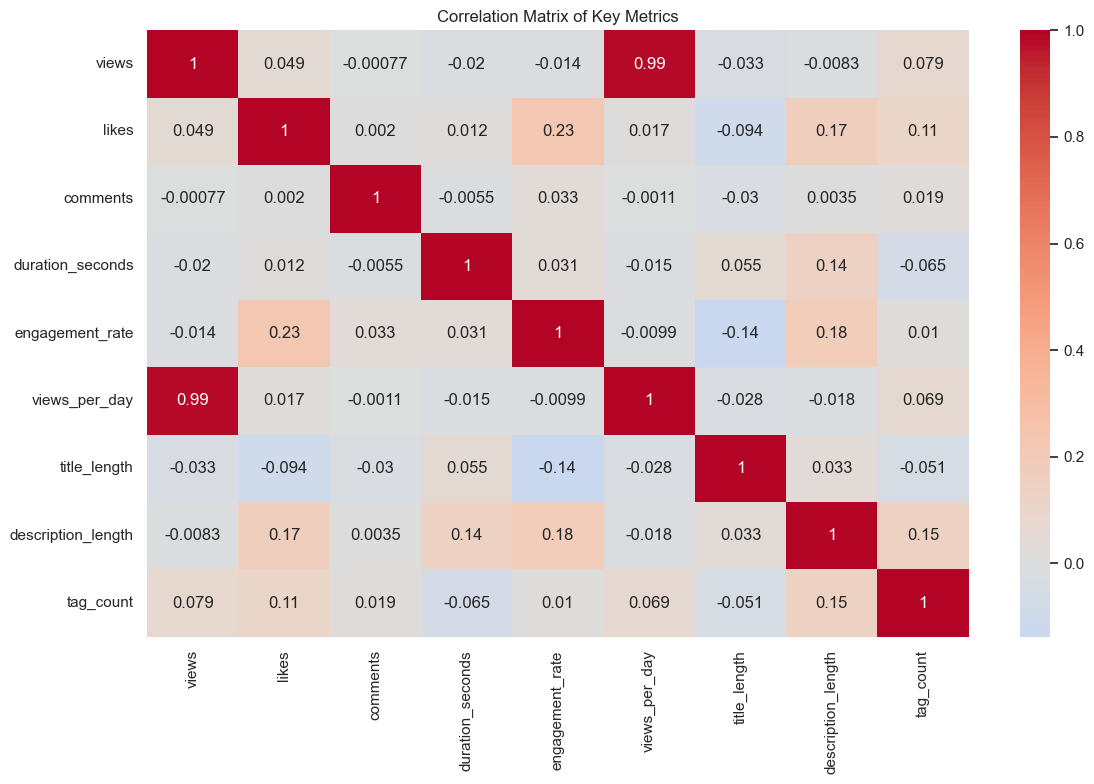

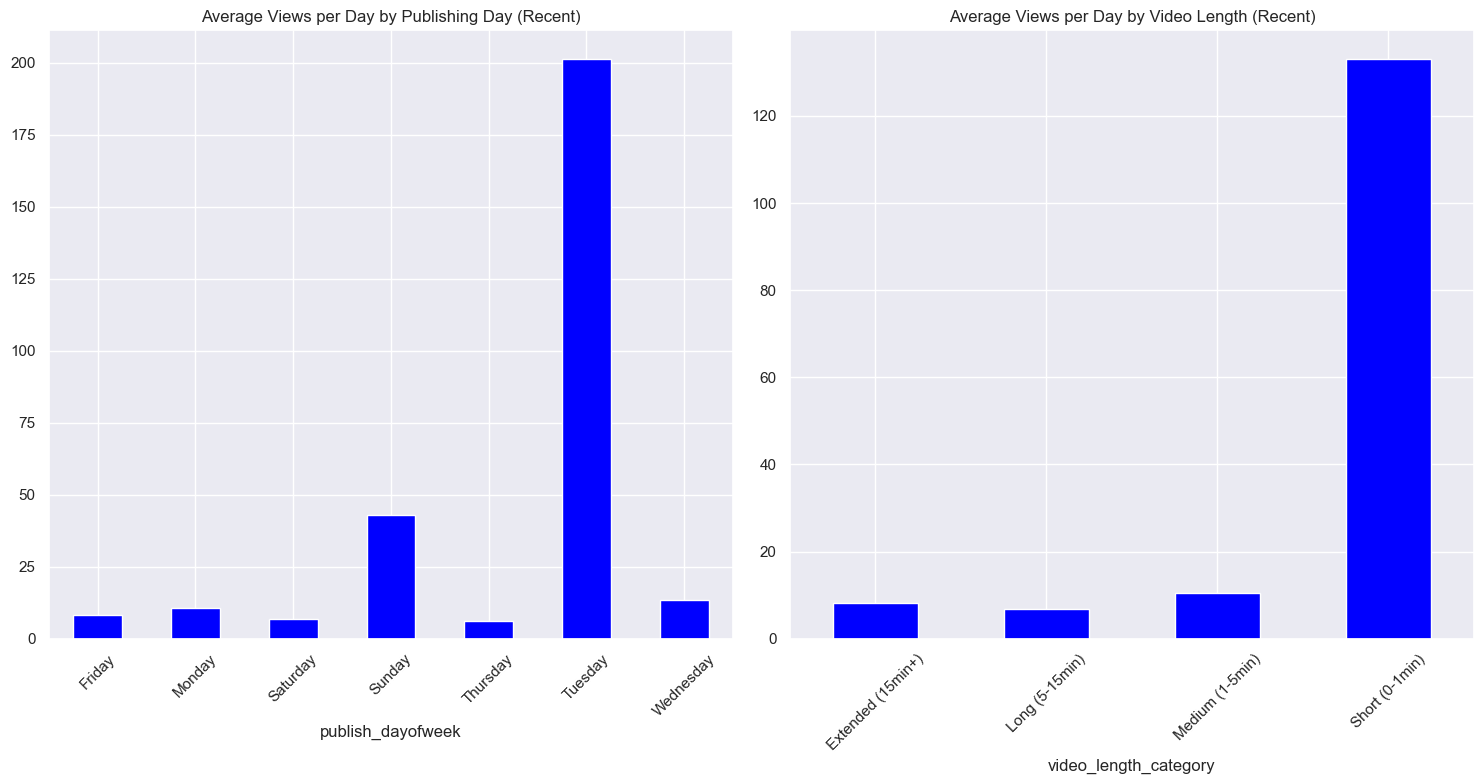

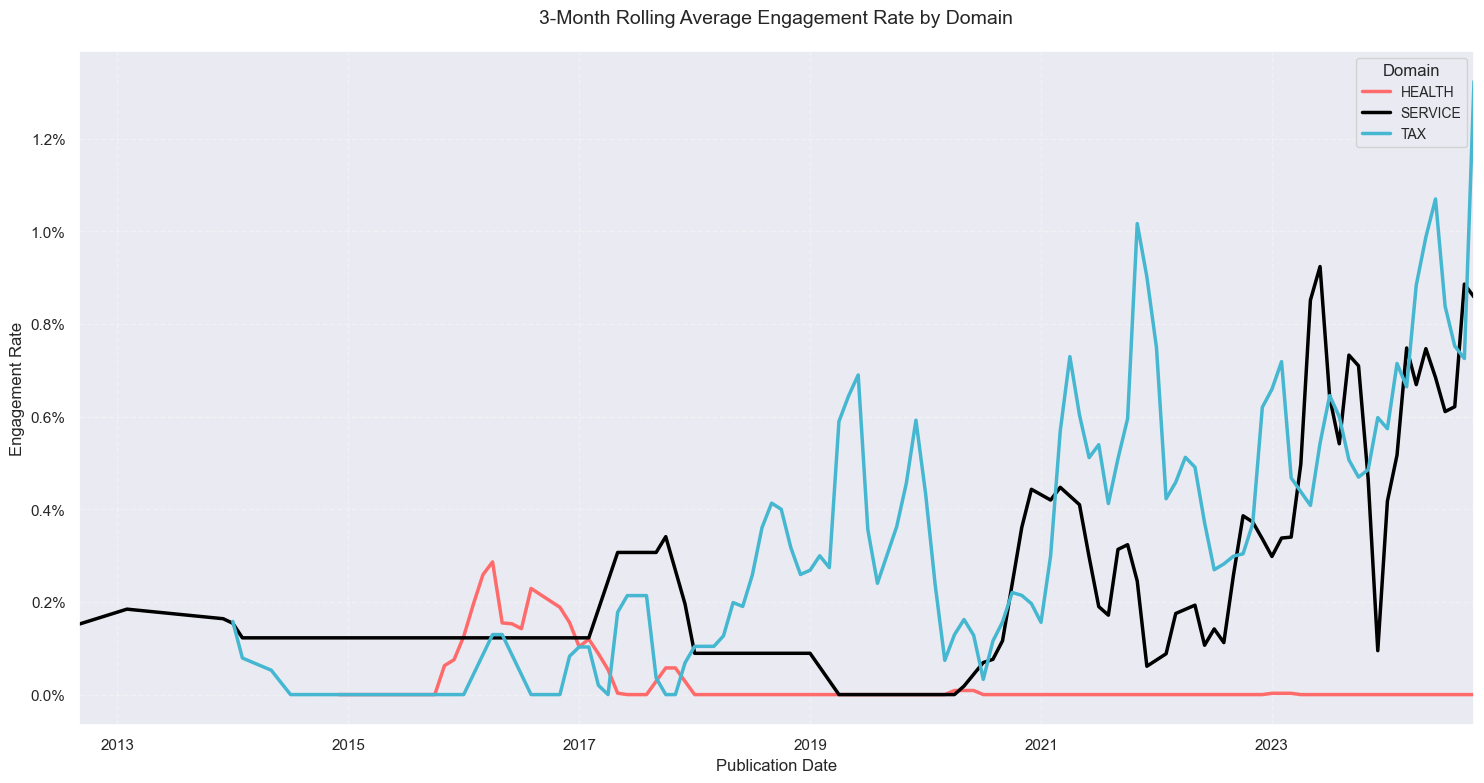


Key Findings:

TAX Domain:
Average views per day: 143.35
Most successful video length: Short (0-1min)
Best publishing day: Tuesday
Average engagement rate: 0.4889%
Maximum engagement rate: 5.0000%
Total number of videos: 590
Total views: 27,405,783
Average views per video: 46450.48
Content distribution percentage: 19.7%

SERVICE Domain:
Average views per day: 16.03
Most successful video length: Extended (15min+)
Best publishing day: Sunday
Average engagement rate: 0.4572%
Maximum engagement rate: 2.6316%
Total number of videos: 192
Total views: 1,566,280
Average views per video: 8157.71
Content distribution percentage: 6.4%

HEALTH Domain:
Average views per day: 2.45
Most successful video length: Long (5-15min)
Best publishing day: Saturday
Average engagement rate: 0.0073%
Maximum engagement rate: 1.0471%
Total number of videos: 2211
Total views: 6,417,225
Average views per video: 2902.41
Content distribution percentage: 73.9%


In [ ]:
# 1. Compare Video Length with Engagement
plt.figure(figsize=(15, 8))
sns.boxplot(data=df, x='video_length_category', y='engagement_rate', hue='domain', palette='Set2')
plt.title('Engagement Rate by Video Length and Domain')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Correlation between Views and Video Characteristics
# Select numerical columns for correlation
numeric_cols = ['views', 'likes', 'comments', 'duration_seconds',
               'engagement_rate', 'views_per_day', 'title_length',
               'description_length', 'tag_count']

# Create correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Key Metrics')
plt.tight_layout()
plt.show()

# 3. Publishing Strategy Analysis
plt.figure(figsize=(15, 8))  # Ensure consistent size
plt.subplot(1, 2, 1)
df_recent = df[df['publish_date'].dt.year >= 2022]  # Last 2 years
success_by_day = df_recent.groupby('publish_dayofweek')['views_per_day'].mean()
success_by_day.plot(kind='bar', color='blue')  # Change to blue
plt.title('Average Views per Day by Publishing Day (Recent)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
success_by_length = df_recent.groupby('video_length_category')['views_per_day'].mean()
success_by_length.plot(kind='bar', color='blue')  # Change to blue
plt.title('Average Views per Day by Video Length (Recent)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Improved Engagement Trends by Content Type
fig, ax = plt.subplots(figsize=(15, 8))  # Create figure and axis explicitly

# Fill missing values and calculate rolling average
engagement_by_month = df.pivot_table(
    index=df['publish_date'].dt.to_period('M'),
    columns='domain',
    values='engagement_rate',
    aggfunc='mean'
).fillna(method='ffill')
smoothed = engagement_by_month.rolling(window=3, min_periods=1).mean()

# Plot with improved styling
smoothed.plot(
    ax=ax,  # Use the explicitly created axis
    linewidth=2.5,
    style={
        'HEALTH': '-',
        'SERVICE': '-',
        'TAX': '-'
    },
    color={
        'HEALTH': '#FF6B6B',  # Red
        'SERVICE': '#000000',  # Black
        'TAX': '#45B7D1'      # Blue
    }
)

plt.title('3-Month Rolling Average Engagement Rate by Domain', pad=20, size=14)
plt.xlabel('Publication Date', size=12)
plt.ylabel('Engagement Rate', size=12)
plt.legend(title='Domain', title_fontsize=12, fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nKey Findings:")
for domain in df['domain'].unique():
    domain_data = df[df['domain'] == domain]
    print(f"\n{domain} Domain:")
    print(f"Average views per day: {domain_data['views_per_day'].mean():.2f}")
    print(f"Most successful video length: {domain_data.groupby('video_length_category')['views_per_day'].mean().idxmax()}")
    print(f"Best publishing day: {domain_data.groupby('publish_dayofweek')['views_per_day'].mean().idxmax()}")

    # Add engagement rate statistics
    print(f"Average engagement rate: {domain_data['engagement_rate'].mean():.4%}")
    print(f"Maximum engagement rate: {domain_data['engagement_rate'].max():.4%}")
    print(f"Total number of videos: {len(domain_data)}")

    # Add view statistics
    print(f"Total views: {domain_data['views'].sum():,}")
    print(f"Average views per video: {domain_data['views'].mean():.2f}")

    # Add content distribution
    print(f"Content distribution percentage: {(len(domain_data) / len(df) * 100):.1f}%")

## 3.1 **Domain-Based Engagement and Content Distribution Analysis**

1. **Engagement Statistics by Domain**:
   - Computes and prints summary statistics (e.g., count, mean, standard deviation) for engagement rates across each domain, providing an overview of engagement distribution and variability by domain.

2. **Engagement Rate Visualization**:
   - Creates a box plot to visually represent the distribution of engagement rates for each domain. This highlights central tendencies, variability, and any potential outliers in engagement across domains.

3. **Content Distribution Analysis**:
   - Calculates and prints the proportion of content attributed to each domain, offering insights into the relative representation of each domain within the dataset. This helps understand the focus of content across different domains.


Engagement Statistics by Domain:
          count      mean       std  min       25%       50%       75%  \
domain                                                                   
HEALTH   2211.0  0.000073  0.000568  0.0  0.000000  0.000000  0.000000   
SERVICE   192.0  0.004572  0.005455  0.0  0.000651  0.002611  0.006127   
TAX       590.0  0.004889  0.005990  0.0  0.000000  0.003296  0.007057   

              max  
domain             
HEALTH   0.010471  
SERVICE  0.026316  
TAX      0.050000  


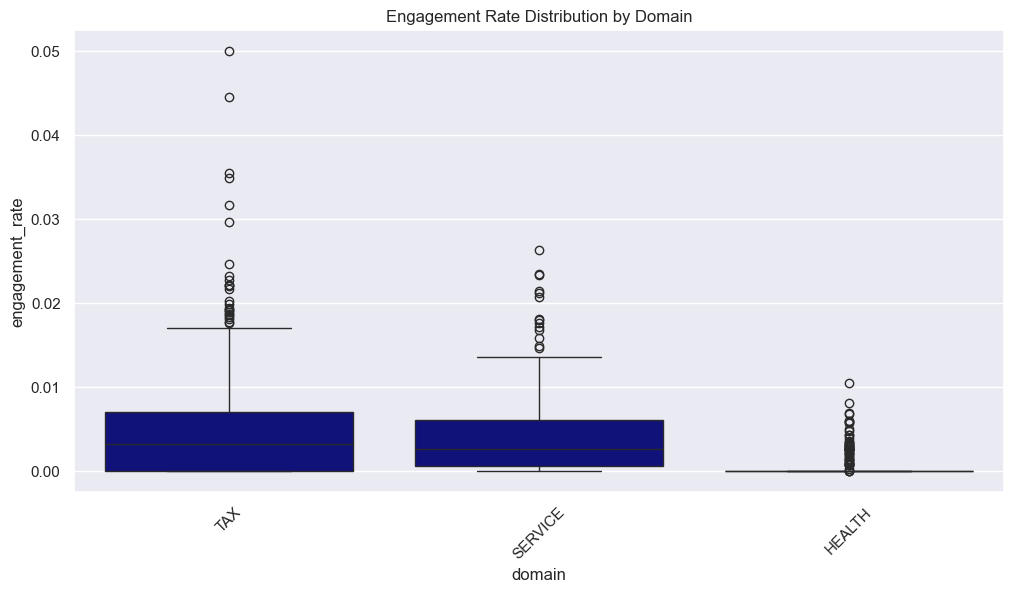


Content Distribution by Domain:
domain
HEALTH     0.738724
TAX        0.197127
SERVICE    0.064150
Name: proportion, dtype: float64


In [ ]:
# Analyze engagement patterns by domain
print("\nEngagement Statistics by Domain:")
print(df.groupby('domain')['engagement_rate'].describe())

# Visualize engagement by domain
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='domain', y='engagement_rate', color='darkblue')
plt.title('Engagement Rate Distribution by Domain')
plt.xticks(rotation=45)
plt.show()

# Check domain distribution
print("\nContent Distribution by Domain:")
print(df['domain'].value_counts(normalize=True))

# 4. **International Tax Agency Video Performance Analysis**

1. **Data Preparation**:
   - A subset, `tax_df`, is created from the main dataset, containing only tax-related content.
   - Each video is categorized by its corresponding tax agency using an `agency_type` column based on channel names for Canadian Revenue Agency (CRA), UK’s HMRC, Australia’s ATO, and New Zealand’s IRD.

2. **Visualization**:
   - **Engagement Rate Comparison**: A box plot illustrates engagement rates by each tax agency, highlighting differences across agencies.
   - **Video Length Impact**: Another box plot examines engagement rates by video length categories, with each category broken down by tax agency.
   - **Views per Day Trend**: A line plot shows the trend of `views_per_day` from 2014 to 2024, enabling time-based performance analysis across agencies.
   - **Content Volume**: A bar chart presents the number of videos published by each agency, showing comparative content production.

3. **Summary Statistics**:
   - Key engagement metrics (e.g., mean and median engagement rate, average views per day, average video duration, and title/description length) are printed for each tax agency, providing quantitative insights into video characteristics and performance.

This analysis offers a comprehensive view of video engagement trends and content strategies among major international tax agencies.

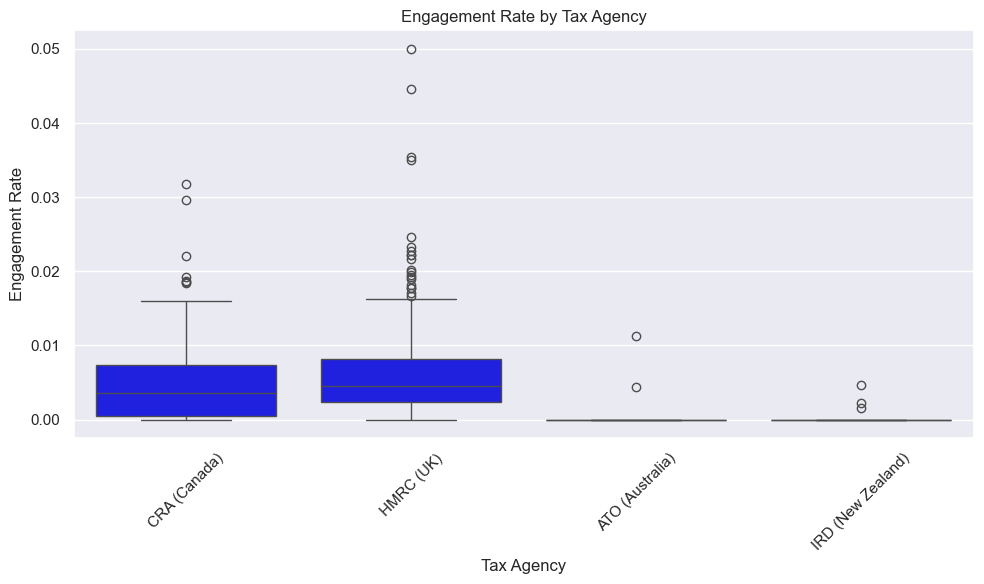

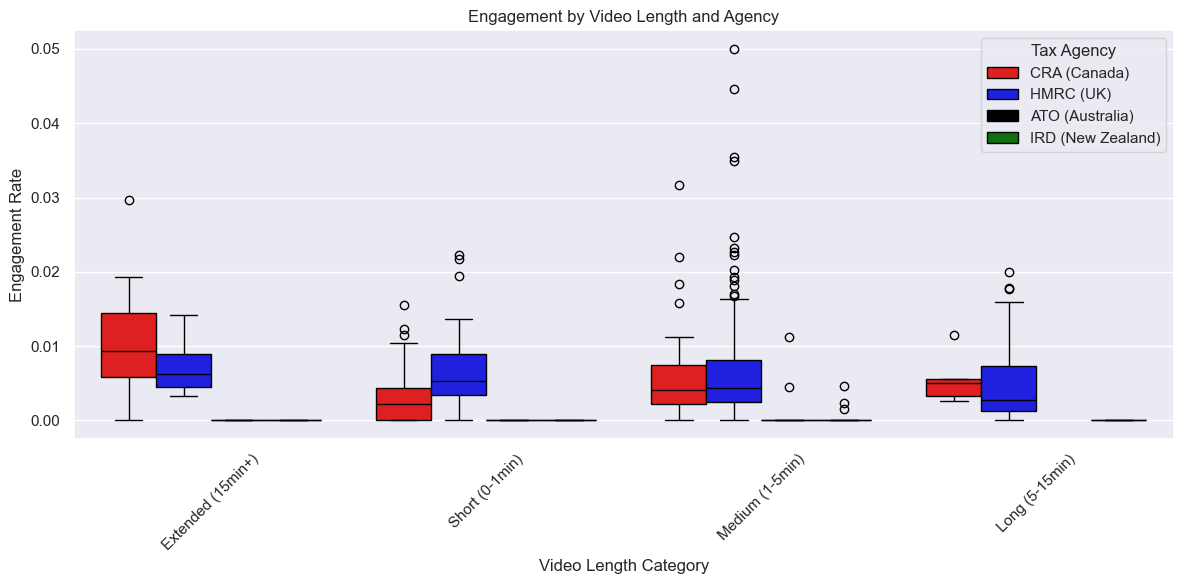

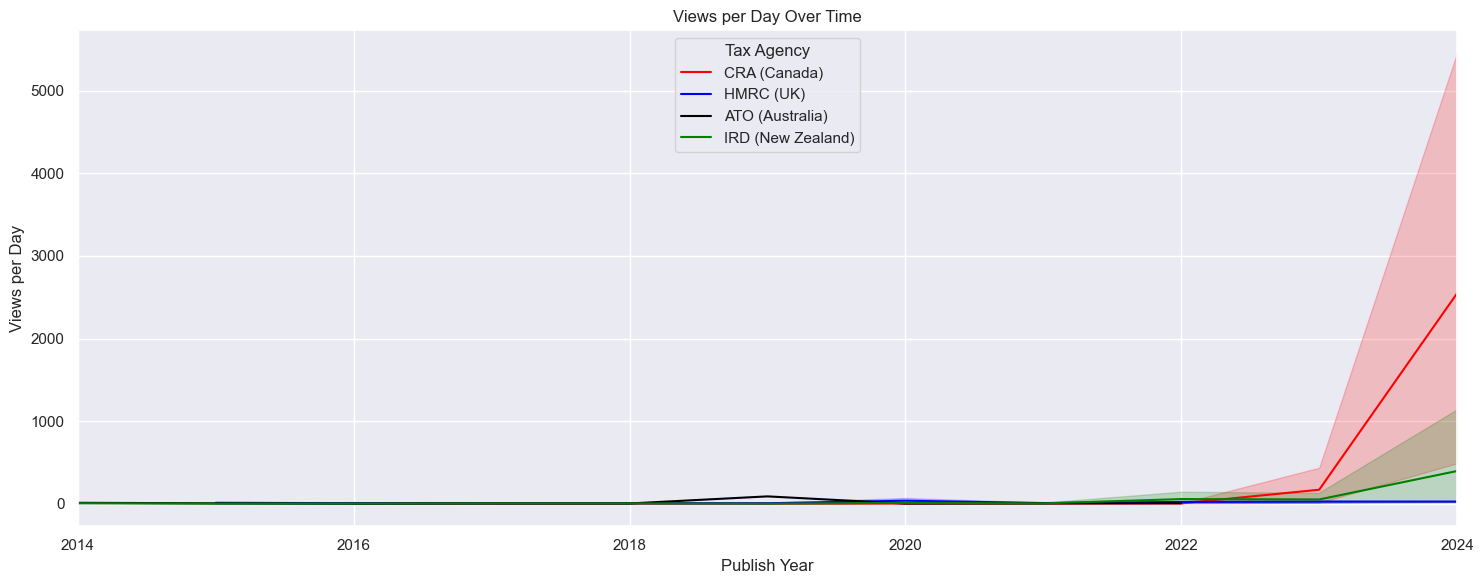

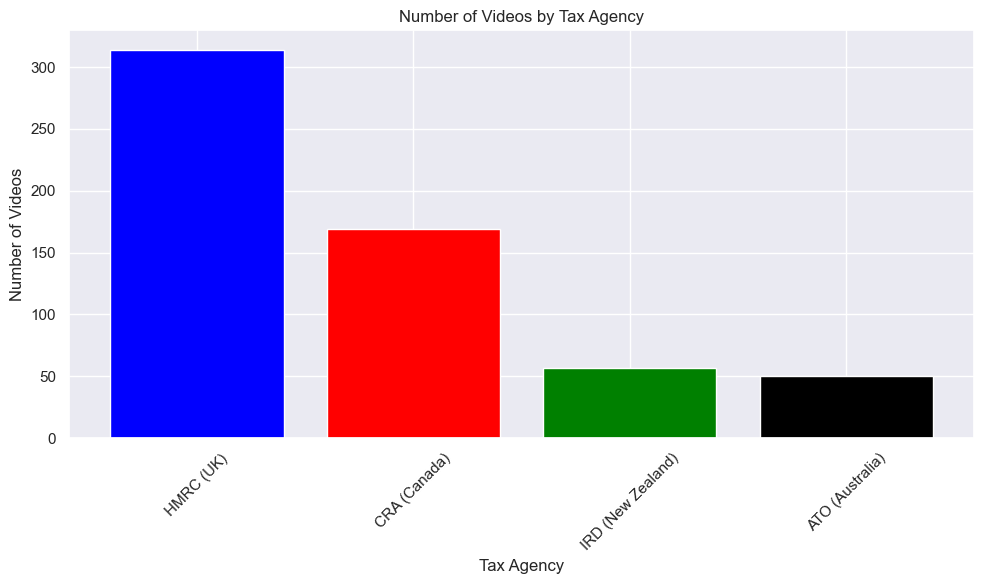


Key Metrics by Tax Agency:
                  engagement_rate              views_per_day         \
                             mean median count          mean median   
agency_type                                                           
ATO (Australia)             0.000  0.000    50         8.284  3.840   
CRA (Canada)                0.005  0.004   169       442.169  1.599   
HMRC (UK)                   0.006  0.004   314        21.776  8.561   
IRD (New Zealand)           0.000  0.000    57        45.538  5.476   

                  duration_seconds title_length description_length tag_count  
                              mean         mean               mean      mean  
agency_type                                                                   
ATO (Australia)            179.360       37.640            252.660    14.700  
CRA (Canada)               393.882       38.065            222.862     9.361  
HMRC (UK)                  274.736       51.621            885.233     8.178  


In [ ]:
# Create tax_df from the main dataframe
tax_df = df[df['domain'] == 'TAX'].copy()

# Create agency_type mapping based on actual channel names
agency_mapping = {
    'canrevagency': 'CRA (Canada)',
    'hmrcgovuk': 'HMRC (UK)',
    'AusTaxOffice': 'ATO (Australia)',
    'InlandRevenueNZ': 'IRD (New Zealand)'
}

# Create agency_type column
tax_df['agency_type'] = tax_df['channel'].map(agency_mapping)

# Define a custom color palette
custom_palette = {
    'ATO (Australia)': 'black',
    'HMRC (UK)': 'blue',
    'CRA (Canada)': 'red',
    'IRD (New Zealand)': 'green'
}

# 1. Engagement Rate Comparison
plt.figure(figsize=(10, 6))
sns.boxplot(data=tax_df, x='agency_type', y='engagement_rate', color='blue')  # Use single color instead of palette
plt.title('Engagement Rate by Tax Agency')
plt.xlabel('Tax Agency')
plt.ylabel('Engagement Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Video Length Impact
plt.figure(figsize=(12, 6))
sns.boxplot(data=tax_df, x='video_length_category', y='engagement_rate', hue='agency_type', palette=custom_palette)
plt.title('Engagement by Video Length and Agency')
plt.xlabel('Video Length Category')
plt.ylabel('Engagement Rate')
plt.xticks(rotation=45)
plt.legend(title='Tax Agency', loc='upper right')
plt.tight_layout()
plt.show()

# 3. Views per Day Trend
plt.figure(figsize=(15, 6))  # Make figure wider to accommodate legend
sns.lineplot(data=tax_df, x='publish_year', y='views_per_day', hue='agency_type', palette=custom_palette)
plt.title('Views per Day Over Time')
plt.xlabel('Publish Year')
plt.ylabel('Views per Day')
plt.legend(title='Tax Agency', loc='upper center')
plt.xlim(2014, 2024)  # Set x-axis limits exactly from 2014 to 2024
plt.tight_layout()
plt.show()

# 4. Content Volume
plt.figure(figsize=(10, 6))
content_counts = tax_df['agency_type'].value_counts()
plt.bar(range(len(content_counts)), content_counts.values, color=[custom_palette[agency] for agency in content_counts.index])
plt.xticks(range(len(content_counts)), content_counts.index, rotation=45)
plt.title('Number of Videos by Tax Agency')
plt.xlabel('Tax Agency')
plt.ylabel('Number of Videos')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nKey Metrics by Tax Agency:")
print(tax_df.groupby('agency_type').agg({
    'engagement_rate': ['mean', 'median', 'count'],
    'views_per_day': ['mean', 'median'],
    'duration_seconds': 'mean',
    'title_length': 'mean',
    'description_length': 'mean',
    'tag_count': 'mean'
}).round(3))